# Модель GARCH

In [351]:
import pandas as pd
import numpy as np
from scipy import stats 

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

import sktime
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
import statsmodels.api as sm

from tqdm import tqdm
from sktime.forecasting.arch import ARCH
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from scipy.stats import boxcox
from scipy.special import inv_boxcox

## Загрузка и подготовка данных

In [352]:
df = pd.read_csv(r"D:\TSML\4._Модели_авторегрессии_условной_гетероскедантичности\international-airline-passengers.csv")
df.head()

,Month,Count
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


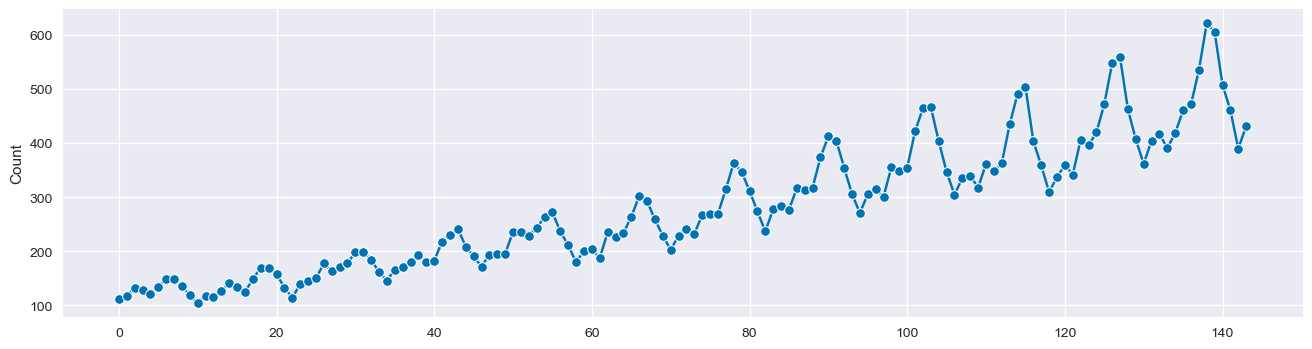

In [353]:
# будем использовать библиотеку sktime

y = df.iloc[:, 1]
plot_series(y)

plt.show()

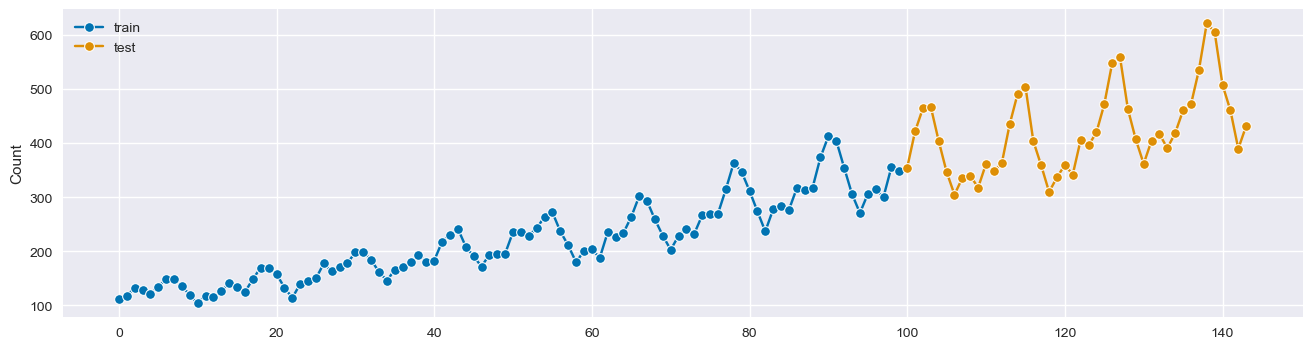

In [354]:
y_train, y_test = temporal_train_test_split(y, test_size=0.3)
plot_series(y_train, y_test, labels=['train', 'test'])

plt.show()

## Создание модели

In [355]:
# заметим явно выраженную месячную сезонность

garch = ARCH(vol='GARCH', mean='AR', lags=12)
y_pred = garch.fit_predict(y_train, fh=range(1, len(y_test) + 1))

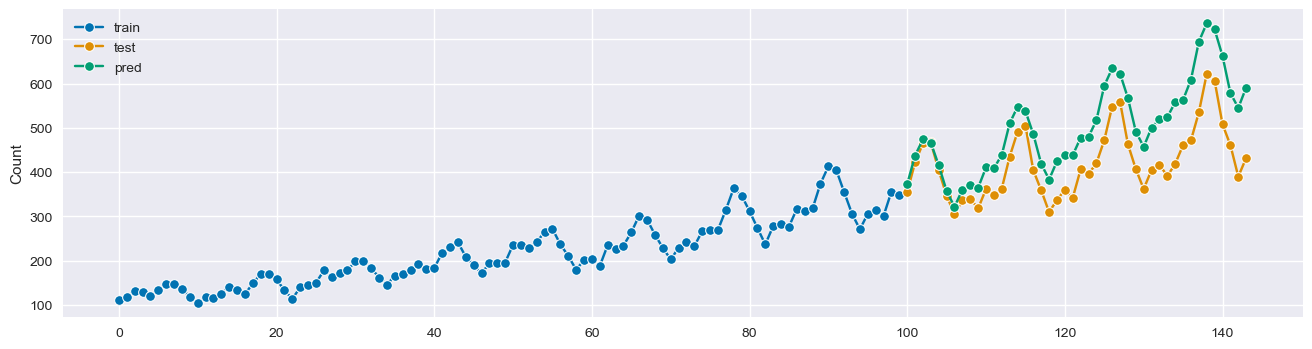

In [356]:
plot_series(y_train, y_test, y_pred, labels=['train', 'test', 'pred'])

plt.show()

## Оценка модели

In [357]:
# в среднем модель ошибается на 18.8 процентов, что довольно много

garch.score(y_test) * 100

18.803410830458052

In [358]:
# объявим функцию для проверки ряда на стационарность

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    def test_stationarity(timeseries):
        print('Results of Dickey-Fuller Test:')
        dftest = adfuller(timeseries, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
        for [key, value] in dftest[4].items():
            dfoutput['Critical Value (%s)' % key] = value
        print(dfoutput)
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                 -0.619394
p-value                         0.866539
#Lags Used                      2.000000
Number of Observations Used    41.000000
Critical Value (1%)            -3.600983
Critical Value (5%)            -2.935135
Critical Value (10%)           -2.605963
dtype: float64


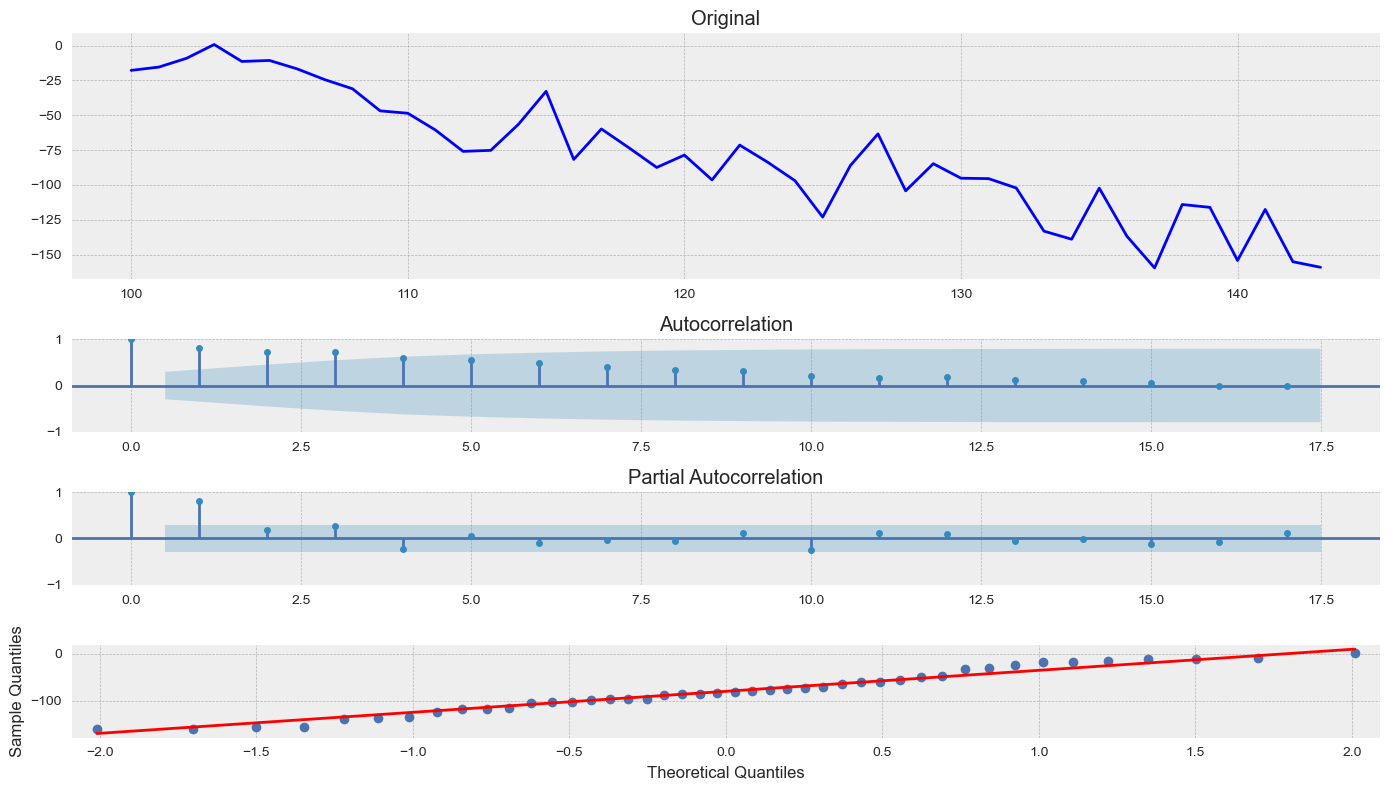

In [359]:
# Видим, что ряд остатков явно не стационарен 

tsplot(garch.predict_residuals(y_test))